Clonamos el repositorio en donde se encuentran los datos

In [1]:
!git clone https://github.com/iserranoz/up_nlp.git

fatal: destination path 'up_nlp' already exists and is not an empty directory.


In [20]:
#Importamos las librerías que usaremos para realizar el análisis

import pandas as pd
import numpy as np
import warnings
import pickle
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
nltk.download('punkt')
nltk.download('stopwords')
warnings.filterwarnings('ignore')


sys.path.insert(0, '/content/up_nlp')
from utils import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cargamos las bases de datos que previamente fueron separadas en test de entrenamiento y de prueba, Adicional creamos la variable "Target" con "1" y "0", donde 1 se referirá a una reseña positiva y 0 a una negativa


In [21]:
df_train = pd.read_parquet('/content/up_nlp/data/data_train.parquet')
df_test = pd.read_parquet('/content/up_nlp/data/data_test.parquet')
df = pd.concat([df_test, df_train], ignore_index=True)

df['target'] = np.where(df['polarity']==2,1,0)
df.head(5)

,polarity,title,text,target
0,2,Get out of the Ratrace!,1985 was the year I realised that the New Wave...,1
1,2,rain gauge,This was the second rain gauge I had purchased...,1
2,2,6 Minute Solutions BETTER than 246 Solved SE P...,I was pleasantly surprised by the time taken w...,1
3,2,quite good,works finesound is good. not wery loud but cla...,1
4,1,Not worth the total price including shipping,You might find the same product locally in som...,0


Ahora hacemos un análisis descriptivo sencillo

In [30]:
# Análisis descriptivo de las variables numéricas
df.describe()

,polarity,target
count,380000.000000,380000.000000
mean,1.500000,0.500000
std,0.500001,0.500001
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.500000,0.500000
75%,2.000000,1.000000
max,2.000000,1.000000


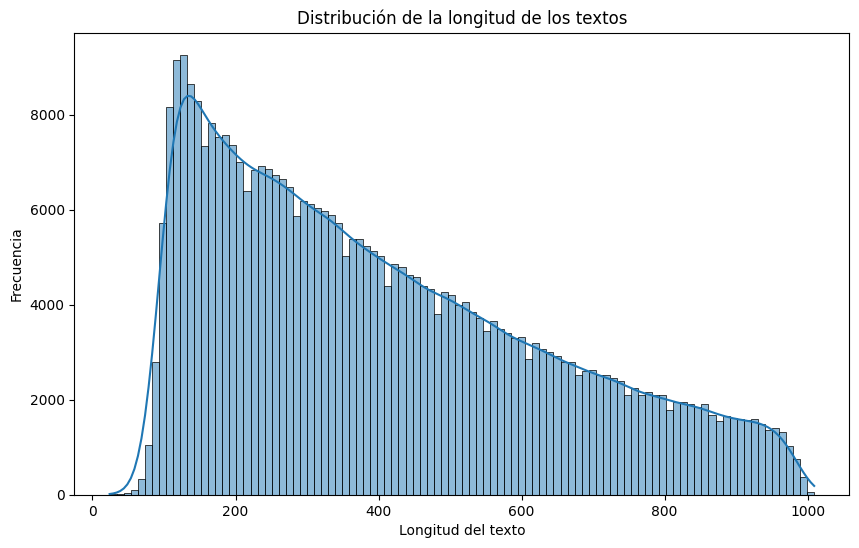

In [36]:
# Longitud de los textos
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], kde=True)
plt.title('Distribución de la longitud de los textos')
plt.xlabel('Longitud del texto')
plt.ylabel('Frecuencia')
plt.show()

A continuación veremos como se encuentra distribuida nuestra variable target, para ver si se trata de un dataset desbalanceado o no



Cuenta de valores positivos y negativos:
 target
1    190000
0    190000
Name: count, dtype: int64


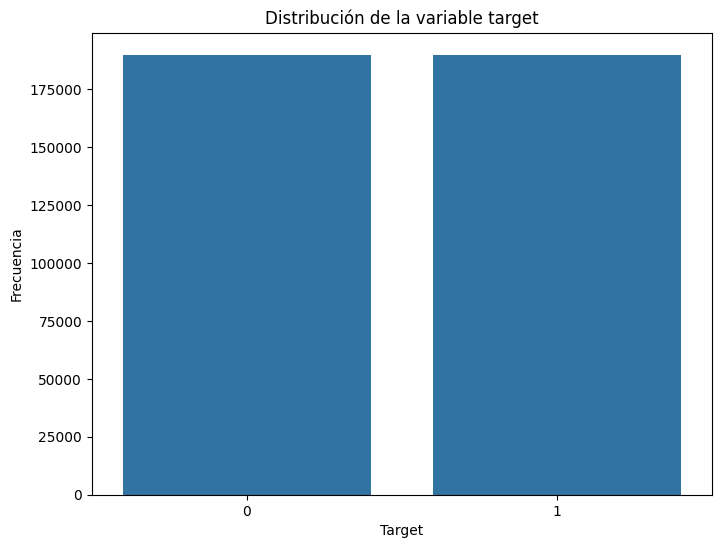

In [22]:
print("\nCuenta de valores positivos y negativos:\n", df['target'].value_counts())
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=df)
plt.title("Distribución de la variable target")
plt.xlabel("Target")
plt.ylabel("Frecuencia")
plt.show()

Generamos nuestra función de procesamiento de texto, en este caso como es texto en Inglés usaremos las Stopwords de ese idioma de donde la función es nativa, de tal manera que esperamos tener buenos resultados

In [23]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    # Convierte el texto a minúsculas y tokeniza
    words = word_tokenize(text.lower())
    # Filtra solo palabras alfanuméricas y elimina stop words
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return ' '.join(words)

Usaremos nuestra función de procesamiento de texto para remover los caracteres especiales y al mismo tiempo poder tokenizar las palabras para poder ver cual se repite más u otro tipo de análisis


In [24]:
df['texto_procesado'] = df['text'].apply(preprocess_text)

In [25]:
df.head(5)

,polarity,title,text,target,texto_procesado
0,2,Get out of the Ratrace!,1985 was the year I realised that the New Wave...,1,1985 year realised new wave british progressiv...
1,2,rain gauge,This was the second rain gauge I had purchased...,1,second rain gauge purchased company happy firs...
2,2,6 Minute Solutions BETTER than 246 Solved SE P...,I was pleasantly surprised by the time taken w...,1,pleasantly surprised time taken review book pr...
3,2,quite good,works finesound is good. not wery loud but cla...,1,works finesound good wery loud claremicrophone...
4,1,Not worth the total price including shipping,You might find the same product locally in som...,0,might find product locally stores price shippi...


Generaremos una gráfica para identificar cuales son las palabras que tienen más frecuencias

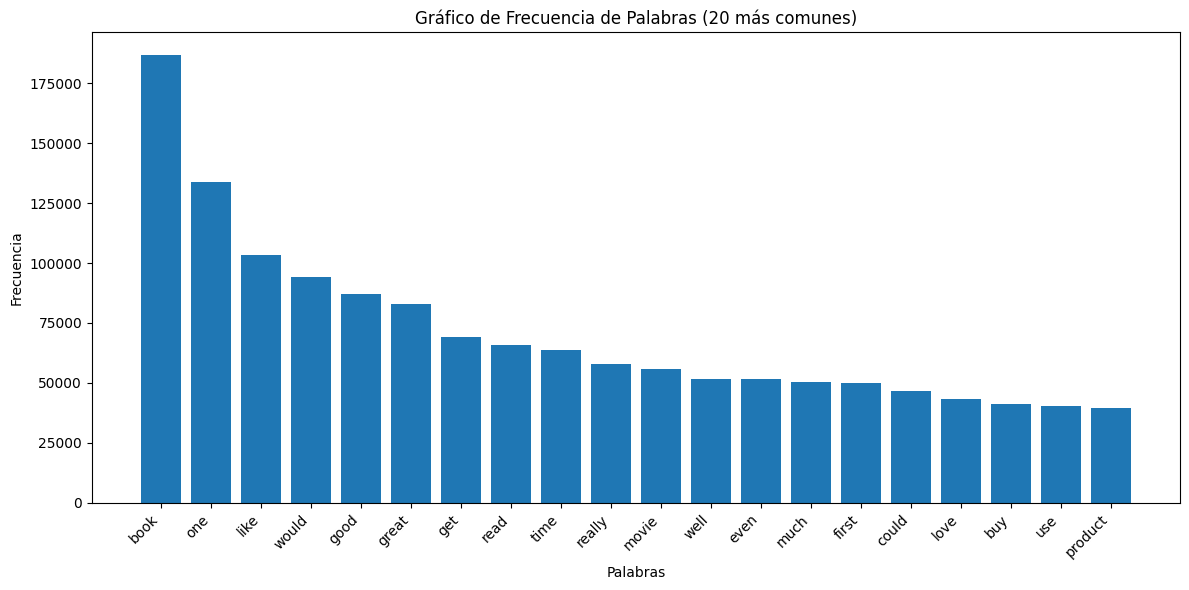

In [27]:
word_counts = Counter(" ".join(df["texto_procesado"]).split())
most_common_words = word_counts.most_common(20)

words = [word for word, count in most_common_words]
frequencies = [count for word, count in most_common_words]

plt.figure(figsize=(12, 6))
plt.bar(words, frequencies)
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.title("Gráfico de Frecuencia de Palabras (20 más comunes)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Vamos ahora a generar la misma gráfica pero separada por target, recordemos que 0=negativo y 1=positivo

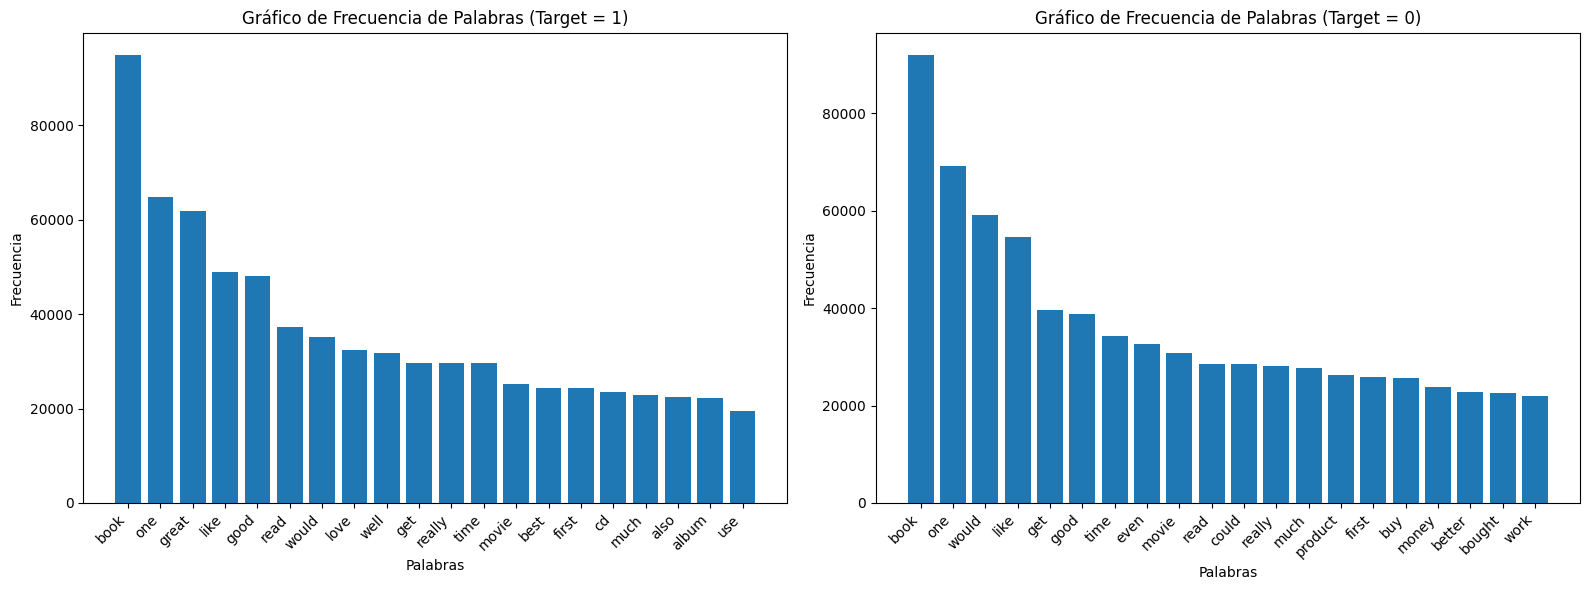

In [29]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
df_target_1 = df[df['target'] == 1]
word_counts_1 = Counter(" ".join(df_target_1["texto_procesado"]).split())
most_common_words_1 = word_counts_1.most_common(20)
words_1 = [word for word, count in most_common_words_1]
frequencies_1 = [count for word, count in most_common_words_1]
plt.bar(words_1, frequencies_1)
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.title("Gráfico de Frecuencia de Palabras (Target = 1)")
plt.xticks(rotation=45, ha="right")

plt.subplot(1, 2, 2)
df_target_0 = df[df['target'] == 0]
word_counts_0 = Counter(" ".join(df_target_0["texto_procesado"]).split())
most_common_words_0 = word_counts_0.most_common(20)
words_0 = [word for word, count in most_common_words_0]
frequencies_0 = [count for word, count in most_common_words_0]
plt.bar(words_0, frequencies_0)
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.title("Gráfico de Frecuencia de Palabras (Target = 0)")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

Por último vamos a generar una nube de palabras por tipo de target

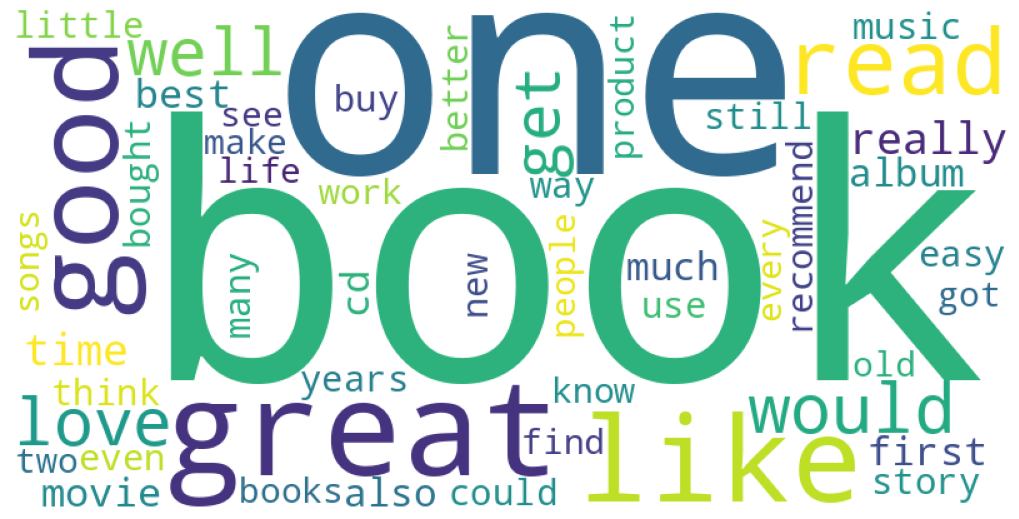

In [41]:
from wordcloud import WordCloud

wordcloud_1 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_counts_1.most_common(50)))

plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(wordcloud_1)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

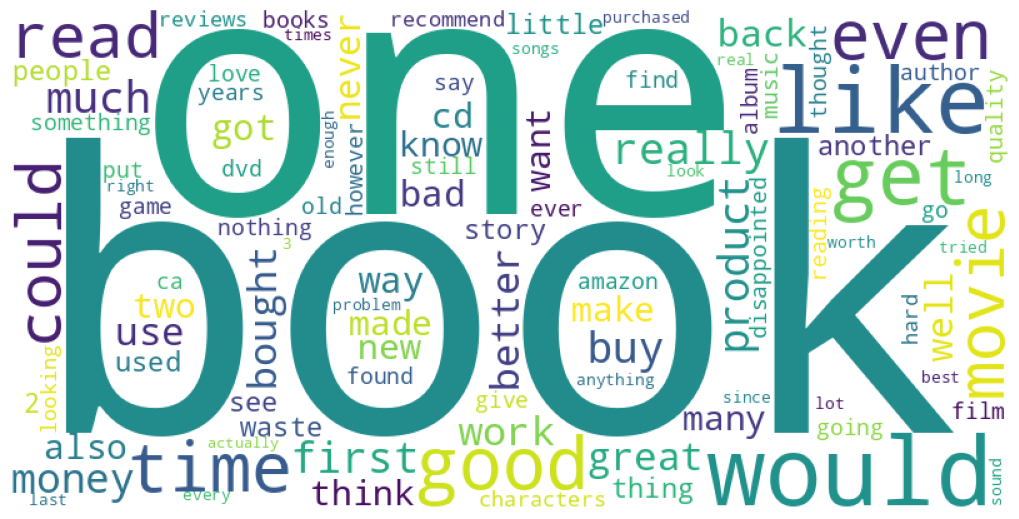

In [43]:
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_counts_0.most_common(100)))

plt.figure(figsize=(10, 5), facecolor=None)
plt.imshow(wordcloud_0)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()